In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule

dm = DataModule(batch_size=4, months=['April'], s1_bands=None)
dm.setup()

train: 8689
test: 2773


In [3]:
x, labels = next(iter(dm.train_dataloader()))
_, s2s = x
s2s.shape, labels.shape, s2s.max(), labels.max(), s2s.min(), labels.min(), s2s.dtype, labels.dtype

(torch.Size([4, 1, 3, 256, 256]),
 torch.Size([4, 256, 256]),
 tensor(1.),
 tensor(0.6598),
 tensor(0.0003),
 tensor(0.),
 torch.float32,
 torch.float32)

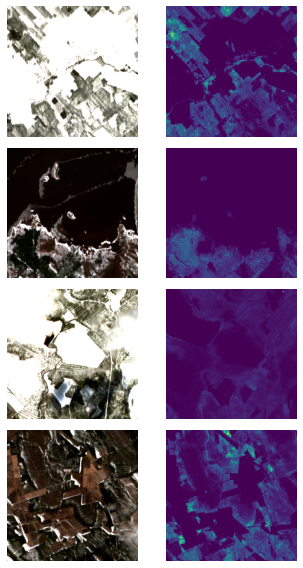

In [4]:
import matplotlib.pyplot as plt

x, labels = next(iter(dm.train_dataloader()))
_, s2s = x
fig = plt.figure(figsize=(5, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 2, 2*i+1)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 2, 2*i+2)
    ax.imshow(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from src.models.unet import UNet

hparams = {
    'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels': 3,
    'p': 0
}

model = UNet(hparams)

outputs, _ = model(x)

outputs.shape

torch.Size([4, 256, 256])

In [11]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4, months=['April'], s1_bands=None)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels': 3,
	'optimizer': 'Adam',
	'p': 0.5,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNet(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | transforms | ModuleList | 0     
1 | unet       | Unet       | 14.3 M
------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.656    Total estimated model params size (MB)


train: 8689
test: 2773


/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

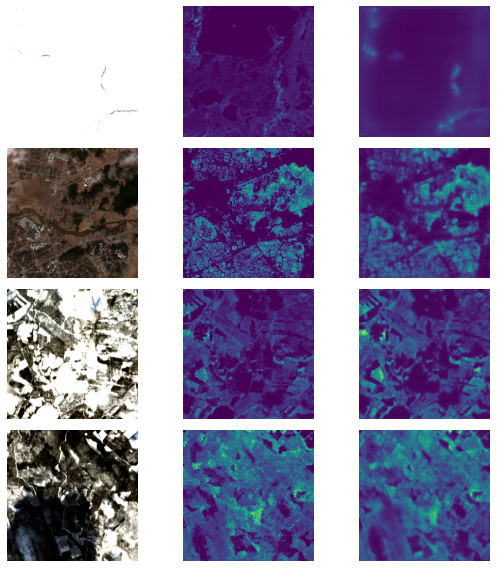

In [12]:
import torch 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 3, 3*i+1)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 3, 3*i+2)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 3, 3*i+3)
    ax.imshow(preds[i])
    ax.axis('off')
    # ax.set_title(torch.mean(torch.sqrt(
    #         torch.mean((preds * 12905.3 - labels * 12905.3)**2, dim=(1, 2)))).item())
plt.tight_layout()
plt.show()